In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# load dataset
dataset = '/content/drive/MyDrive/가천대학교/2022-2/머신러닝/팀프로젝트/amazon.csv'


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def data_clean(df, feature, m):
    count = df[feature].value_counts()
    df = df[df[feature].isin(count[count > m].index)]
    return df


def data_clean_sum(df,features,m):
    # take the data which the user and item appear more than 10 times
    fil = df.ProductId.value_counts()
    fil2 = df.UserId.value_counts()
    df['#Proudcts'] = df.ProductId.apply(lambda x: fil[x])
    df['#Users'] = df.UserId.apply(lambda x: fil2[x])
    while (df.ProductId.value_counts(ascending=True)[0]) < m or  (df.UserId.value_counts(ascending=True)[0] < m):
        df = data_clean(df,features[0],m)
        df = data_clean(df,features[1],m)
    return df


def data(dataset):
    df = pd.read_csv(dataset, encoding = "ISO-8859-1")
    df['datetime'] = pd.to_datetime(df.Time, unit='s')
    raw_data = data_clean_sum(df, ['ProductId', 'UserId'], 10)
    # encoding userid and productid
    raw_data['uid'] = pd.factorize(raw_data['UserId'])[0]
    raw_data['pid'] = pd.factorize(raw_data['ProductId'])[0]
    # scaling time, nuber of users and nuber of products
    sc = MinMaxScaler()
    raw_data['time']=sc.fit_transform(raw_data['Time'].values.reshape(-1,1))
    raw_data['nuser']=sc.fit_transform(raw_data['#Users'].values.reshape(-1,1))
    raw_data['nproduct']=sc.fit_transform(raw_data['#Proudcts'].values.reshape(-1,1))
    # Sepreate the features into three groups
    X1 = raw_data.loc[:,['uid','pid']]
    X2 = raw_data.loc[:,['uid','pid','time']]
    X3 = raw_data.loc[:,['uid','pid','time','nuser','nproduct']]
    y = raw_data.Score # target = score
    # train_test split
    X1_train,X1_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,random_state=2017)
    X2_train,X2_test,y_train,y_test = train_test_split(X2,y,test_size=0.3,random_state=2017)
    X3_train,X3_test,y_train,y_test = train_test_split(X3,y,test_size=0.3,random_state=2017)
    train = np.array(X1_train.join(y_train))
    test = np.array(X1_test.join(y_test))
    # got the productId to pid index
    pid2PID = raw_data.ProductId.unique()
    
    # make a table of mathches between productid and userid
    data_mixed = X1.join(y) # X1 + y
    total_p = data_mixed['pid'].unique().shape[0]
    total_u = data_mixed['uid'].unique().shape[0]
    # make the user-item table
    table = np.zeros([total_u,total_p])
    z = np.array(data_mixed)
    for line in z:
        u,p,s = line
        if table[u][p] < s:
            table[u][p] = s #if some one score a single thing several times
    print('The table\'s shape is:' )
    print(table.shape)
    return z, total_u,total_p,pid2PID,train,test,table,raw_data

z, total_u,total_p,pid2PID,train,test,table,raw_data = data(dataset)

The table's shape is:
(3666, 1102)


In [5]:
# read csv dataset
# imoprt numpy, pandas, TfidfVectorizer, linear_kernel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

data = pd.read_csv(dataset, encoding = "ISO-8859-1")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",NaN
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# use data ProductId, review Text feature

data = data[['ProductId','Text']]

# clean dirty data (null data)
print(data.isnull().sum())

data = data.dropna()
data = data.drop_duplicates()

# Original dataset is about 500,000
# Because it's too big, we reduced it's size to 20,000

data = data[0:20000]

print(data.shape)
data.head(5)

ProductId     0
Text         11
dtype: int64
(20000, 2)


,ProductId,Text
0,B001E4KFG0,I have bought several of the Vitality canned d...
1,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...
3,B000UA0QIQ,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,Great taffy at a great price. There was a wid...
5,B006K2ZZ7K,I got a wild hair for taffy and ordered this f...


In [7]:
# TfidfVectorizer to vectorize text

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
tfidf_matrix = tfidf.fit_transform(data['Text'])

In [8]:
# Cosine simularity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
 
# change it's form into pandas dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=data.index, columns=data.index)
 
# index is the product 
# concate with product id to find product by it's ID
indices = pd.Series(data.index, index=data['ProductId'])

In [9]:
# Content-based recommendation function (product ID, top n)

def content_recommender(productId, n_of_recomm):
    # get product index from the product ID
    idx = indices[productId]
    
    # get the similarity between the given producet and other products
    sim_scores = cosine_sim[idx]
    
    # set the similarity as a standard and get n products (top n)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]

    # return product ID
    return data.loc[sim_scores.index][['ProductId','Text']]

In [10]:
# B001E4KFG0 = dog food
# 1st - B001TM3XKW = dog food
# 2nd -  B000N5XCPM = dog treat

print(content_recommender('B001E4KFG0', 20))

        ProductId                                               Text
18318  B001TM3XKW  Although this is very expensive canned dog foo...
2172   B000N5XCPM  This canned food has real chunks of chicken in...
12642  B000N648JA  I've been feeding my dog Merrick canned food m...
8282   B000VK6NDC  This is an excellent quality product. I have a...
7801   B00474H936  Very meaty texture for a vegetarian product.  ...
14205  B0045XE32E  My mountain feist (a breed that is similar to ...
7937   B000RHXIGO  The product was better than expected and it ar...
1590   B001CWZXIY  My dog loves, loves  this dog food.I had to sa...
13491  B002MXSAD2  We have a friend that recommended this to us. ...
19605  B000084ETV  This is by far the best dog food I've given my...
8270   B000VK6NDC  I have three cats... have had cats for years, ...
19703  B0030VBRIU  I wanted this for the omega 3's but my daughte...
1591   B001CWZXIY  I have purchased this product once before from...
10680  B00389Q4XW  This product wo

In [33]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def caculate_mse(x):
    MSE1=[]
    MSE2=[]
    for line in train:
        u,p,s = line
        MSE1.append(s)
        MSE2.append(x[u,p])
    MSE_in_sample = mean_squared_error(MSE1,MSE2)
    MSE3=[]
    MSE4 = []
    for line in test:
        u,p,s = line
        MSE3.append(s)
        MSE4.append(x[u,p])
    MSE_out_sample = mean_squared_error(MSE3,MSE4)
    print('Train data MSE = {} \nTest data sample MSE = {}\n'.format(MSE_in_sample,MSE_out_sample))
    return MSE_in_sample,MSE_out_sample


def draw_mse(method,maxIter):
    import time
    c = []
    d = []
    timetime = []
    for i in [1,2,5,7,10,20,50,70,100]:
        tic = time.time()
        data = method(factors=i,maxIter=maxIter)
        a,b = caculate_mse(data)
        c.append(a)
        d.append(b)
        toc = time.time()
        timetime.append(toc-tic)
    aa = [1, 2, 5, 7, 10, 20, 50, 70, 100]
    for i in range(len(timetime)):

        print('latent factors = {}, time = {}'.format(aa[i],timetime[i]))
    plt.figure()
    plt.plot(aa,c,label = 'in_sample_MSE')
    plt.plot(aa,d,label = 'out_sample_MSE')
    plt.xticks([1,2,5,7,10,20,50,70,100])
    plt.legend()
    plt.show()
    return 0


import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def drawcm(y_pred,y_test =test ,title = ''):
    y1=[]
    y2=[]
    for line in y_test:
        u,p,s = line
        y1.append(s)
        y2.append(y_pred[u,p])
    temp1 = []
    temp2 = []
    for i in range(len(y1)):
        if np.array(y1)[i] >= 4:
            temp1.append(1)
        elif np.array(y1)[i] <= 2:
            temp1.append(0)
        else:
            temp1.append(0)
        if y2[i] >= 4:
            temp2.append(1)
        elif y2[i] <= 2:
            temp2.append(0)
        else:
            temp2.append(0)
    cm = confusion_matrix(temp1,temp2)
    plt.figure()
    classes = ['not','recommand']
    plot_confusion_matrix(cm, classes, normalize=True,
                          title=title)
    plt.show()

Train data MSE = 2.1815326081122333 
Test data sample MSE = 2.2582779695854374



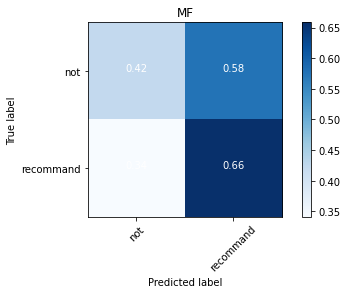


The top10 recommanded products for user 10 is [ 644  151  455   52 1072 1051  127 1067  106    0]


The real ID is ['B0058AMYTC' 'B00472I5A4' 'B0058AMY10' 'B0058AMY74' 'B001SAXPEO'
 'B006WYSFZK' 'B000G6MBUA' 'B004728MI4' 'B0012XBD7I' 'B000G6RYNE']



array([ 644,  151,  455,   52, 1072, 1051,  127, 1067,  106,    0])

In [34]:
from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a
result =cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 10,10,rawId= True)

In [35]:
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('the top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('the real ID is {}'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N

Train data MSE = 2.1815326081122333 
Test data sample MSE = 2.2582779695854374



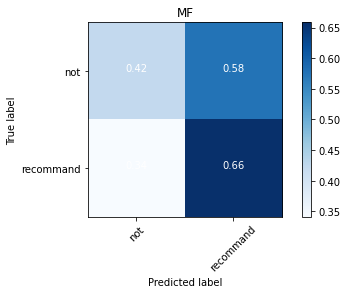

the top5 recommanded products for user 0 is [1067  455  644  918    0]
the real ID is ['B004728MI4' 'B0058AMY10' 'B0058AMYTC' 'B000G6O2QG' 'B000G6RYNE']


array([1067,  455,  644,  918,    0])

In [36]:
from sklearn.metrics.pairwise import pairwise_distances
def cf(table = table,distance = 'cosine'):
    user_similarity = pairwise_distances(table, metric=distance)
    item_similarity = pairwise_distances(table.T, metric=distance)
    sc = MinMaxScaler(feature_range=(1,5))
    a = sc.fit_transform(np.dot(user_similarity,table).dot(item_similarity))
    return a
result=cf()
caculate_mse(result)
drawcm(result,title='MF')
rec(result, 0,5,rawId= True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Train data MSE = 0.3982335596954265 
Test data sample MSE = 0.39813597209585744



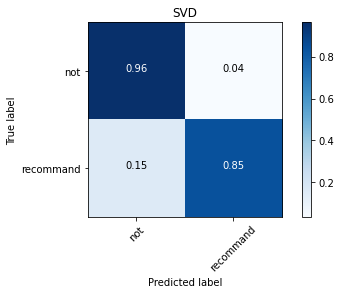


The top10 recommanded products for user 10 is [1072  967  216  127  106  799   52 1051  644    0]

The real ID is ['B001SAXPEO' 'B000LKVD5U' 'B000LKXBL4' 'B000G6MBUA' 'B0012XBD7I'
 'B0058AMY5G' 'B0058AMY74' 'B006WYSFZK' 'B0058AMYTC' 'B000G6RYNE']



array([1072,  967,  216,  127,  106,  799,   52, 1051,  644,    0])

In [37]:
from numpy import *
from scipy.sparse.linalg import svds
from numpy import linalg as la
from sklearn.preprocessing import MinMaxScaler
def svdrec(table = table, factors= 150):
    UI = matrix(table)
    # ui_df = pd.DataFrame(UI,index=table.index, columns=table.columns)
    user_ratings_mean=mean(UI,axis=0)
    user_ratings_mean=user_ratings_mean.reshape(1,-1)
    UI_demeaned=UI-user_ratings_mean
    U,sigma,Vt=svds(UI_demeaned,factors)
    sigma=diag(sigma)
    pred_mat=dot(dot(U,sigma),Vt) + user_ratings_mean
    sc=MinMaxScaler(feature_range = (1,5))
    pred_mat = sc.fit_transform(pred_mat)
    # prediction_df=pd.DataFrame(pred_mat,index=table.index,columns=table.columns)
    return pred_mat
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('\nThe top{} recommanded products for user {} is {}'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('\nThe real ID is {}\n'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
result1 =svdrec(factors=150)
caculate_mse(result1)
drawcm(result1,title='SVD')
rec(result1, 10,10,rawId= True)

iter = 1, loss = 3302.059613423433, delta_loss = -3302.059613423433, LR = 0.02
iter = 2, loss = 959.6309938760915, delta_loss = 2342.4286195473414, LR = 0.01
iter = 3, loss = 621.8245736686856, delta_loss = 337.80642020740584, LR = 0.0105
iter = 4, loss = 573.3953638240434, delta_loss = 48.42920984464217, LR = 0.011025000000000002
iter = 5, loss = 538.5347262535772, delta_loss = 34.860637570466224, LR = 0.011576250000000003
iter = 6, loss = 503.0460761150978, delta_loss = 35.48865013847944, LR = 0.012155062500000004
iter = 7, loss = 463.65504465103686, delta_loss = 39.391031464060916, LR = 0.012762815625000005
iter = 8, loss = 421.3315043756761, delta_loss = 42.323540275360756, LR = 0.013400956406250006
iter = 9, loss = 378.3764794840278, delta_loss = 42.95502489164829, LR = 0.014071004226562506
iter = 10, loss = 336.49896272393244, delta_loss = 41.877516760095375, LR = 0.014774554437890632
iter = 11, loss = 296.7861559422512, delta_loss = 39.71280678168125, LR = 0.015513282159785164
i

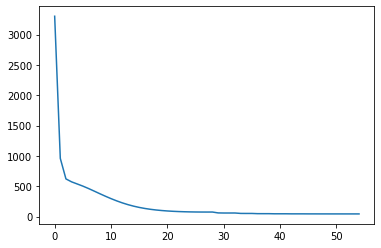

Train data MSE = 0.03536341096753518 
Test data sample MSE = 0.03380491052695071



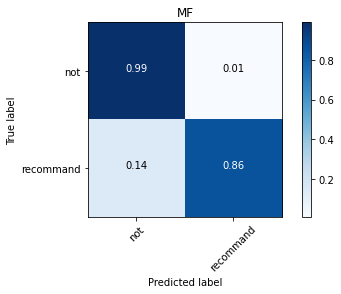


The top10 recommanded products for user 10 is [ 243  182  256   96 1093  201  448   80  996  155]


The real ID is ['B001KVPBS4' 'B004HOLD4W' 'B004HOQE64' 'B004HOLD92' 'B004HOSGWE'
 'B001EQ4QJK' 'B001LNTY70' 'B001EQ4P2I' 'B004HOLD60' 'B001EQ4RBM']



array([ 243,  182,  256,   96, 1093,  201,  448,   80,  996,  155])

In [38]:
def MF1(data=z, factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=False):
    # initial the latent matrix for user and item
    P = np.random.rand(total_u, factors) / 3
    Q = np.random.rand(total_p, factors) / 3
    # initial y as the history of loss
    y = []
    # initial the iteration and last loss
    iteration = 0
    last_loss = 0
    while iteration < maxIter:
        loss = 0
        for i in range(data.shape[0]):
            # get the uid,pid and the score from every line
            u, p, s = data[i]
            # calculate the error
            error = s - np.dot(P[u], Q[p])
            # calculate the loss function
            # avoid loss become to large, scale to 1/50
            loss += error ** 2 / 50
            # update the parameter according to the gradient descent
            pp = P[u]
            qq = Q[p]
            P[u] += LRate * error * qq
            Q[p] += LRate * error * pp
        iteration += 1
        y.append(loss)
        delta_loss = last_loss - loss
        print('iter = {}, loss = {}, delta_loss = {}, LR = {}'.format(iteration, loss, delta_loss, LRate))
        # update the learn rate to make sure it will converge
        if abs(last_loss) > abs(loss):
            LRate *= 1.05
        else:
            LRate *= 0.5
        # When converge, stop the gradient descend
        if abs(delta_loss) < abs(GD_end):
            print('the diff in loss is {}, so the GD stops'.format(delta_loss))
            break
        last_loss = loss
    if plot:
        plt.plot(y)
        plt.show()
    return P.dot(Q.T)

result =MF1( factors=30, maxIter=100, LRate=0.02, GD_end=1e-3, plot=1)
caculate_mse(result)
drawcm(result,title='MF')
def rec(result, uid,n,rawId= False):
    if uid in range(total_u):
		# we take the first n people's highest score product
        top_N = np.argpartition(result[uid],-n)[-n:]
        print('\nThe top{} recommanded products for user {} is {}\n'.format(n,uid,top_N))
		# if rawID is on, the out put contains the real product id
        if rawId == True:
            print('\nThe real ID is {}\n'.format(pid2PID[top_N]))
    else:
        print('this user has not bought anything, plz use other methods')
    return top_N
rec(result, 10,10,rawId= True)